# 🔍 CNN-Based Handwritten Digit Classification with PyTorch on MNIST
This notebook demonstrates a complete machine learning workflow for image classification using a Convolutional Neural Network (CNN) implemented in PyTorch, applied to the classic MNIST handwritten digit dataset. The project includes data loading, preprocessing, exploratory data analysis (EDA), CNN model definition and training, and comprehensive evaluation with visualizations.

In [1]:
# Cell 1: Import libraries and set global configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')

# Jupyter visualization settings
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Cell 2: Load and prepare MNIST dataset
# Define data transformations
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load train and test datasets
train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform_train)
test_dataset = datasets.MNIST(root='../../data', train=False, download=True, transform=transform_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


In [ ]:
# Cell 3: Exploratory Data Analysis
# Visualize sample images and class distribution
fig, axes = plt.subplots(2, 5, figsize=(5, 2))
for i in range(10):
    idx = np.random.choice(np.where(train_dataset.targets.numpy() == i)[0])
    img, label = train_dataset[idx]
    axes[i//5, i%5].imshow(img.squeeze(), cmap='viridis')
    axes[i//5, i%5].set_title(f'Label: {label}')
    axes[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()

# Plot class distribution
plt.figure(figsize=(6, 3))
sns.countplot(x=train_dataset.targets.numpy(), palette='viridis')
plt.title('Distribution of Digit Classes in Training Set')
plt.xlabel('Digit Class')
plt.ylabel('Count')
plt.show()

In [12]:
# Cell 4: Define CNN model architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)

        # Second convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second conv block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Flatten and fully connected layers
        x = x.view(-1, 128 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

print(f"Model initialized on {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Model initialized on cuda
Total parameters: 3457162


In [13]:
# Cell 5: Train the CNN model with progress tracking
def train_model(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in tqdm(range(epochs), desc="Training Progress", ncols=80, colour='green'):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        if (epoch + 1) % 2 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    return train_losses, train_accuracies

# Train the model
train_losses, train_accuracies = train_model(model, train_loader, optimizer, criterion, epochs=10)

Training Progress:  20%|█████                    | 2/10 [00:44<03:02, 22.76s/it]

Epoch 2/10, Loss: 0.0565, Accuracy: 98.30%


Training Progress:  40%|██████████               | 4/10 [01:23<02:02, 20.40s/it]

Epoch 4/10, Loss: 0.0358, Accuracy: 98.95%


Training Progress:  60%|███████████████          | 6/10 [02:09<01:26, 21.68s/it]

Epoch 6/10, Loss: 0.0266, Accuracy: 99.21%


Training Progress:  80%|████████████████████     | 8/10 [02:47<00:40, 20.28s/it]

Epoch 8/10, Loss: 0.0220, Accuracy: 99.32%


Training Progress: 100%|████████████████████████| 10/10 [03:23<00:00, 20.39s/it]

Epoch 10/10, Loss: 0.0178, Accuracy: 99.43%


Test Loss: 0.0000, Test Accuracy: 99.36%


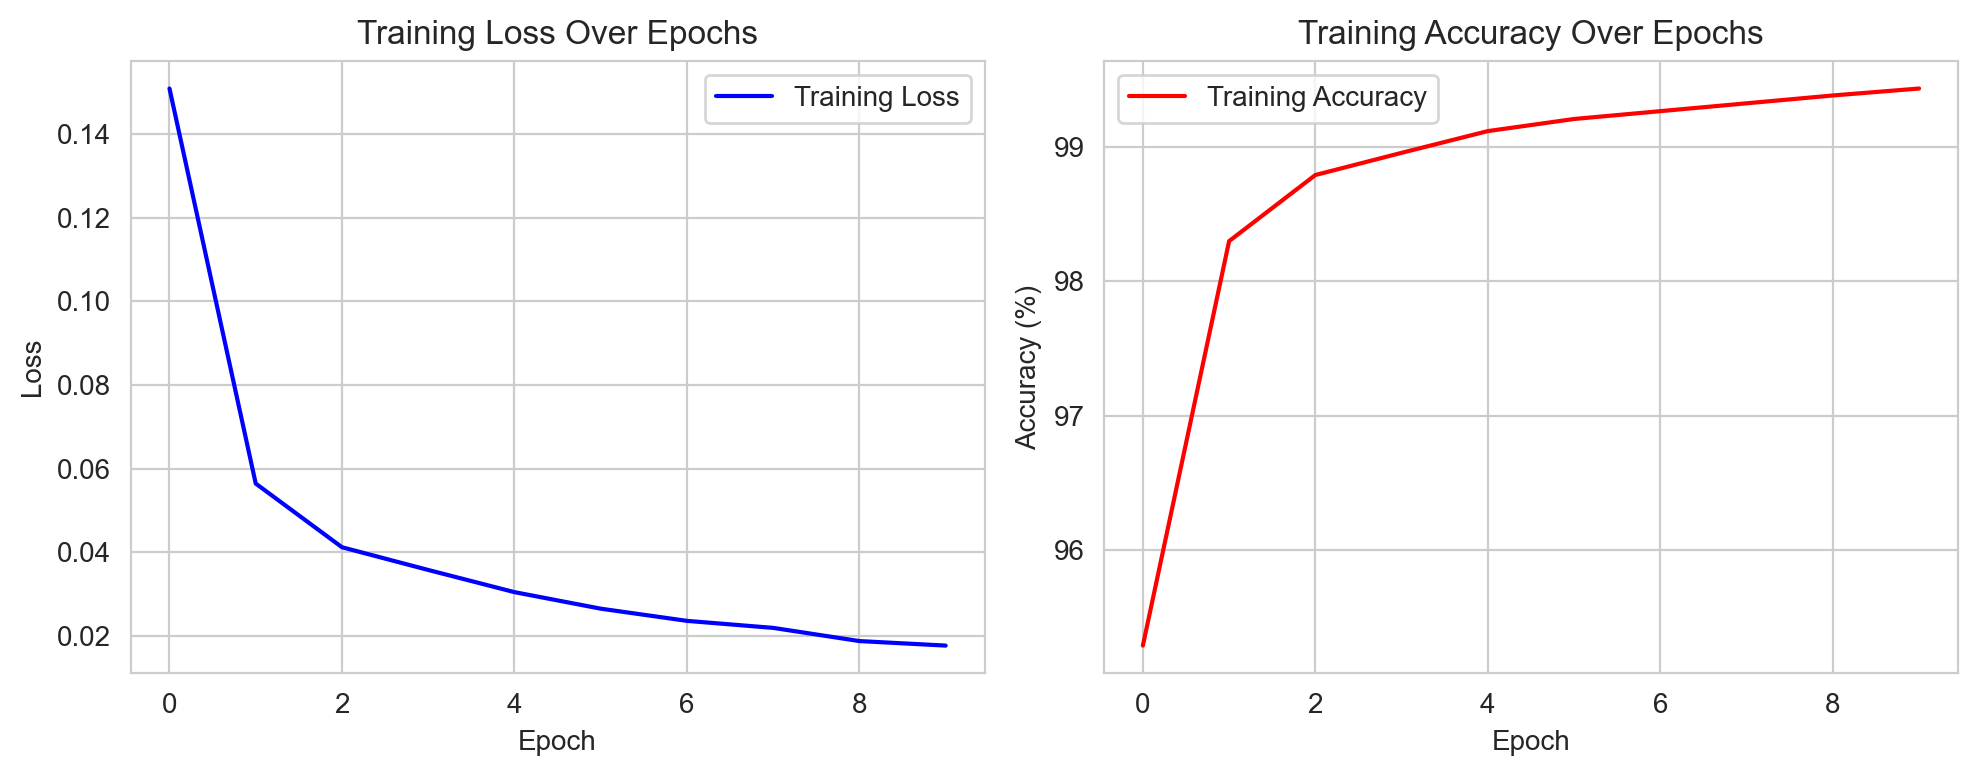

In [16]:
# Cell 6: Evaluate model and visualize results
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, test_accuracy, all_preds, all_targets

# Evaluate the model
test_loss, test_accuracy, all_preds, all_targets = evaluate_model(model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(train_losses, color='blue', label='Training Loss')
ax1.set_title('Training Loss Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, color='red', label='Training Accuracy')
ax2.set_title('Training Accuracy Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      1.00       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       0.99      1.00      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



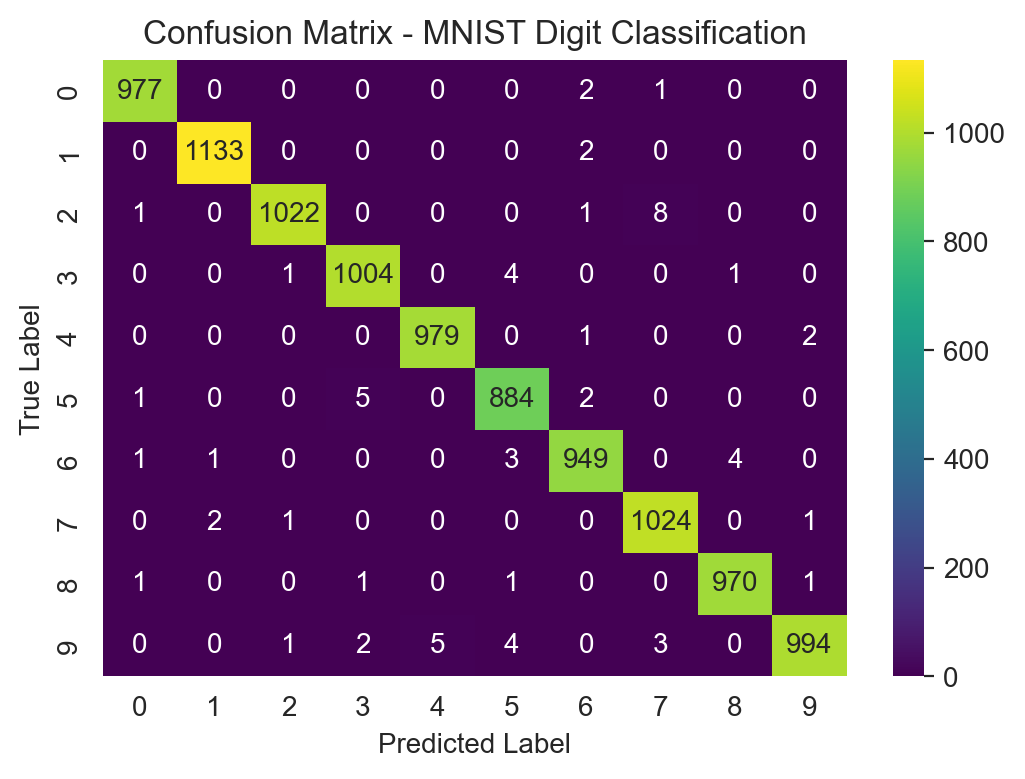

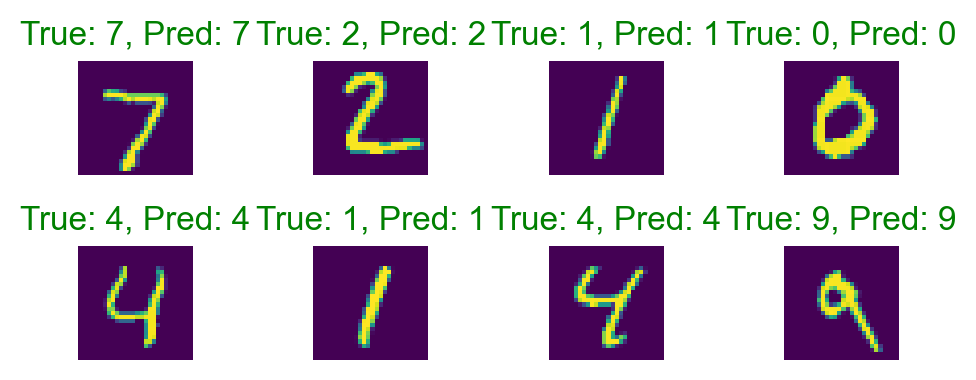

In [22]:
# Cell 7: Detailed evaluation and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Generate classification report
print("Classification Report:")
print(classification_report(all_targets, all_preds))

# Create and visualize confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - MNIST Digit Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Visualize some test predictions
def visualize_predictions(model, test_loader, num_samples=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(5, 2))

    count = 0
    for data, target in test_loader:
        if count >= num_samples:
            break
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        for i in range(data.size(0)):
            if count >= num_samples:
                break
            ax = axes[count//4, count%4]
            ax.imshow(data[i].cpu().squeeze(), cmap='viridis')
            true_label = target[i].item()
            pred_label = pred[i].item()
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f'True: {true_label}, Pred: {pred_label}', color=color)
            ax.axis('off')
            count += 1

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)

Per-Class Performance Summary:
   Digit  Precision  Recall  F1-Score  Support
0      0      0.996   0.997     0.996      980
1      1      0.997   0.998     0.998     1135
2      2      0.997   0.990     0.994     1032
3      3      0.992   0.994     0.993     1010
4      4      0.995   0.997     0.996      982
5      5      0.987   0.991     0.989      892
6      6      0.992   0.991     0.991      958
7      7      0.988   0.996     0.992     1028
8      8      0.995   0.996     0.995      974
9      9      0.996   0.985     0.991     1009


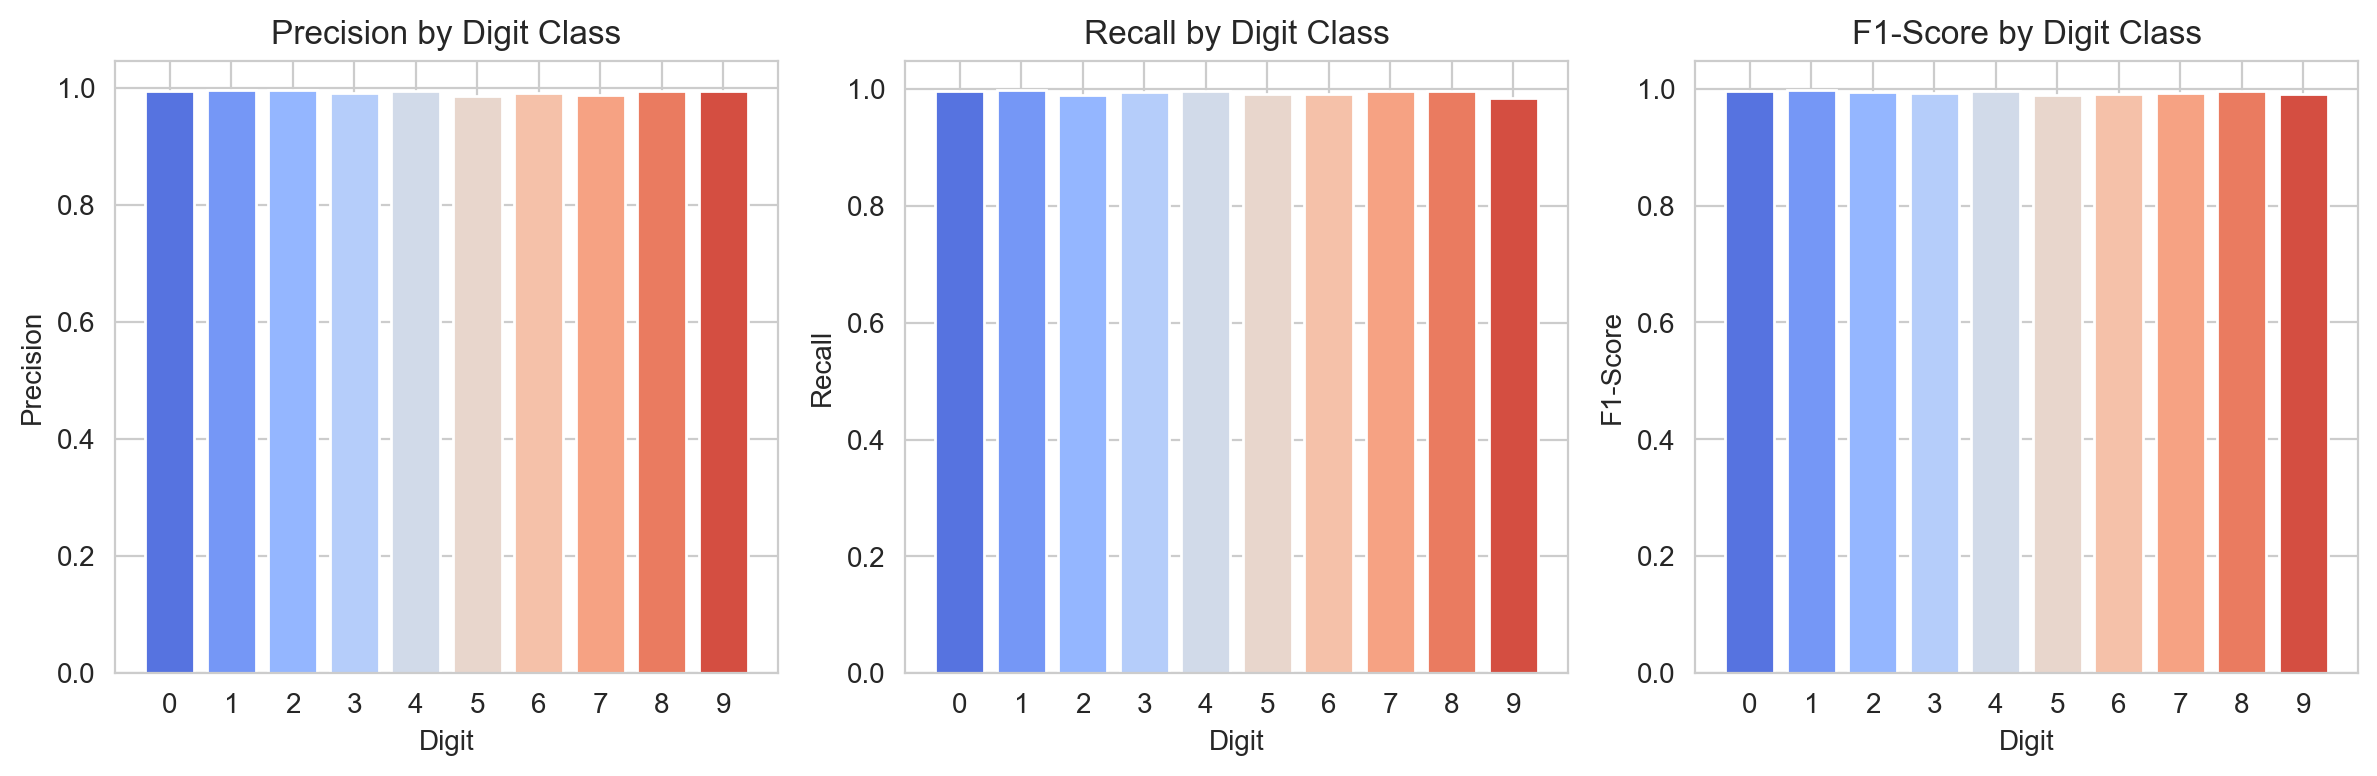


Final Model Performance:
Test Accuracy: 99.36%
Overall Precision: 0.993
Overall Recall: 0.994
Overall F1-Score: 0.994


In [24]:
# Cell 8: Model performance summary and insights
# Calculate per-class accuracy
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(all_targets, all_preds, average=None)

# Create performance summary dataframe
performance_df = pd.DataFrame({
    'Digit': range(10),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("Per-Class Performance Summary:")
print(performance_df.round(3))

# Visualize per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1]

for i, (metric, value) in enumerate(zip(metrics, values)):
    axes[i].bar(range(10), value, color=sns.color_palette('coolwarm', 10))
    axes[i].set_title(f'{metric} by Digit Class')
    axes[i].set_xlabel('Digit')
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(range(10))

plt.tight_layout()
plt.show()

print(f"\nFinal Model Performance:")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Overall Precision: {np.mean(precision):.3f}")
print(f"Overall Recall: {np.mean(recall):.3f}")
print(f"Overall F1-Score: {np.mean(f1):.3f}")